# Wine Grape Variety Recognition 

In [1]:
import csv
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import pandas as pd

## Data Processing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Project

/content/gdrive/MyDrive/EngSci 2T1 + PEY/Year 4/Summer/APS360/Project


In [4]:
header = ['Index', 'Description', 'Variety']
df = pd.read_csv("winemag-data-100k.csv", names=header, index_col=False)
df = df[['Description', 'Variety']][1:]

In [5]:
df.shape

(72410, 2)

In [6]:
variety_count = df['Variety'].value_counts()
to_remove = variety_count[variety_count < 652].index
df = df[~df.Variety.isin(to_remove)]

In [7]:
df.shape

(57331, 2)

In [8]:
df['Variety'].value_counts()

Pinot Noir                    8268
Chardonnay                    6119
Bordeaux-style Red Blend      4535
Red Blends                    4432
Cabernet Sauvignon            4326
Rosé                          2770
Sauvignon Blanc               2579
Riesling                      2529
Syrah                         2090
Rhône-style Red Blend         1945
Nebbiolo                      1680
Sparkling Blend               1643
Sangiovese                    1621
Portuguese Red                1535
Gamay                         1477
Zinfandel                     1172
Malbec                        1083
Merlot                        1071
White Blend                    930
Champagne Blend                869
Tempranillo                    868
Cabernet Franc                 854
Pinot Gris                     793
Portuguese White               786
Grüner Veltliner               704
Bordeaux-style White Blend     652
Name: Variety, dtype: int64

In [9]:
class_weights = torch.tensor(df['Variety'].value_counts().tolist())
class_weights = 1/class_weights

In [10]:
class_weights

tensor([0.0001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0004, 0.0004, 0.0004, 0.0005,
        0.0005, 0.0006, 0.0006, 0.0006, 0.0007, 0.0007, 0.0009, 0.0009, 0.0009,
        0.0011, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0014, 0.0015])

In [11]:
class_weights.shape

torch.Size([26])

In [12]:
variety_values = df['Variety'].unique()

def get_variety_onehot_from_value(value):
    onehot = np.zeros(26)
    onehot[np.where(variety_values == value)] = 1
    return onehot

def get_variety_label(value):
    return np.where(get_variety_onehot_from_value(value) == 1)[0]

def get_variety_onehot_from_label(label):
    onehot = np.zeros(26)
    onehot[round(label)] = 1
    return onehot

def get_variety_value(label):
    return variety_values[np.argmax(get_variety_onehot_from_label(label))]

In [13]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_word(review):
    # separate punctuations
    review = review.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return review.lower().split()

### CNN

Input word vectors with constant dimensions of 50.

In [ ]:
def get_word_vectors_cnn(glove_vector):
    i = 0
    train, valid, test = [], [], []
    for line in df.values:
        review = line[0]
        if i < 5000:
            word_emb = sum(glove_vector[w] for w in split_word(review))
            label = torch.tensor(get_variety_onehot(line[1]), dtype=torch.float32)
            if i % 10 < 8:
                train.append((word_emb, label)) # 80% training
            elif i % 10 == 9:
                valid.append((word_emb, label)) # 10% validation
            else:
                test.append((word_emb, label)) # 10% test
        i += 1
    return train, valid, test

In [ ]:
train, valid, test = get_word_vectors_cnn(glove)

print("The number of entries in the training set is", len(train))
print("The number of entries in the validation set is", len(valid))
print("The number of entries in the test set is", len(test))

The number of entries in the training set is 4000
The number of entries in the validation set is 500
The number of entries in the test set is 500


In [ ]:
for i in range(5):
    review, label = train[i]
    print(review.shape)
    print(label)
    print()

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

torch.Size([50])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])



### RNN & LSTM

Input word vectors with variable dimensions. 

In [14]:
def get_word_vectors_rnn(glove_vector):
    i = 0
    train, valid, test = [], [], []
    for line in df.values:
        review = line[0]
        if i < 57331:
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_word(review)
                    if w in glove_vector.stoi]  # keep words that has an embedding
            if not idxs:                        # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs)           # convert list to pytorch tensor
            label = torch.tensor(get_variety_label(line[1])).long()
            if i % 10 < 8:
                train.append((idxs, label))
            elif i % 10 == 9:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        i += 1
    return train, valid, test

In [15]:
train, valid, test = get_word_vectors_rnn(glove)

print("The number of entries in the training set is", len(train))
print("The number of entries in the validation set is", len(valid))
print("The number of entries in the test set is", len(test))

The number of entries in the training set is 45865
The number of entries in the validation set is 5733
The number of entries in the test set is 5733


In [16]:
for i in range(5):
    review, label = train[i]
    print(review.shape)
    print(label)
    print()

torch.Size([70])
tensor([0])

torch.Size([70])
tensor([1])

torch.Size([74])
tensor([1])

torch.Size([80])
tensor([2])

torch.Size([52])
tensor([3])



## Model Setup

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        x = self.emb(x)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        out, _ = self.rnn(x, (h0, c0))
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

## Training

In [19]:
import random

class ReviewBatcher:
    def __init__(self, reviews, batch_size=32, shuffle=True, drop_last=False):
        self.words_by_length = {}
        for words, label in reviews:
            wlen = words.shape[0]
            if wlen not in self.words_by_length:
                self.words_by_length[wlen] = []
            self.words_by_length[wlen].append((words, label),)
         
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    reviews,
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    drop_last=drop_last)
            for wlen, reviews in self.words_by_length.items()}
        
    def __iter__(self): 
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

In [20]:
def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0
    for reviews, labels in train_loader:
        if use_cuda and torch.cuda.is_available():
            reviews = reviews.cuda()
            labels = labels.cuda()
        pred = model(reviews)
        loss = criterion(pred, labels.squeeze())
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

In [21]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for reviews, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            reviews = reviews.cuda()
            labels = labels.cuda()
        output = model(reviews)
        output_np = output.cpu().detach().numpy()
        pred = np.argmax(output_np, axis=1)
        labels_np = labels.cpu().numpy()
        truth = np.squeeze(labels_np)
        correct += (pred==truth).sum()
        total += labels.shape[0]
    return correct / total

In [22]:
def train_RNN(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(1000)          
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    epochs = []

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        i = 0
        for reviews, labels in train_loader:
            optimizer.zero_grad()
            if use_cuda and torch.cuda.is_available():
                reviews = reviews.cuda()
                labels = labels.cuda()
            pred = model(reviews)
            loss = criterion(pred, labels.squeeze())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            i += 1
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        train_loss.append(float(total_train_loss)/(i + 1))
        val_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_val_loss(model, valid_loader, criterion))
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_loss[-1],
                   val_acc[-1],
                   val_loss[-1]))
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [23]:
train_loader = ReviewBatcher(train, batch_size=64, drop_last=True)
valid_loader = ReviewBatcher(valid, batch_size=64, drop_last=False)

Epoch 1: Train acc: 0.34073795180722893, Train loss: 2.686487819467272 |Validation acc: 0.31453362255965295, Validation loss: 2.354003517400651
Epoch 2: Train acc: 0.4348644578313253, Train loss: 2.2017284347897483 |Validation acc: 0.3947939262472885, Validation loss: 1.9019984702269237
Epoch 3: Train acc: 0.5111069277108434, Train loss: 1.8735063260509854 |Validation acc: 0.4544468546637744, Validation loss: 1.6755728054614294
Epoch 4: Train acc: 0.5353915662650602, Train loss: 1.689340977441697 |Validation acc: 0.49023861171366595, Validation loss: 1.542491322471982
Epoch 5: Train acc: 0.572289156626506, Train loss: 1.5797937682696752 |Validation acc: 0.5065075921908894, Validation loss: 1.3932448795863561
Epoch 6: Train acc: 0.5713478915662651, Train loss: 1.4399081397624243 |Validation acc: 0.5032537960954447, Validation loss: 1.3585917027223677
Epoch 7: Train acc: 0.604480421686747, Train loss: 1.378517522698357 |Validation acc: 0.5325379609544468, Validation loss: 1.2821365687109

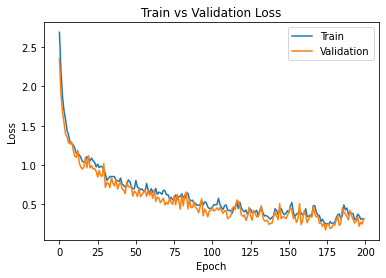

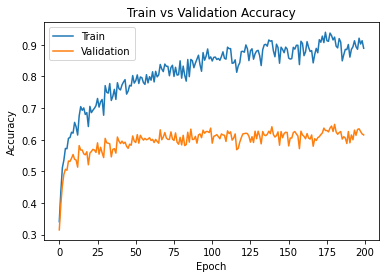

Final Training Accuracy: 0.8893072289156626
Final Validation Accuracy: 0.6149674620390455


In [ ]:
model = RNN(50, 200, 26)
train_RNN(model, train_loader, valid_loader, num_epochs=200, learning_rate=5e-3)

Epoch 1: Train acc: 0.4006024096385542, Train loss: 2.4704124203750064 |Validation acc: 0.37310195227765725, Validation loss: 1.9385166125638145
Epoch 2: Train acc: 0.5608057228915663, Train loss: 1.7301890481086004 |Validation acc: 0.5075921908893709, Validation loss: 1.4707561972595395
Epoch 3: Train acc: 0.6423192771084337, Train loss: 1.3821542135306768 |Validation acc: 0.5585683297180043, Validation loss: 1.1888762336401713
Epoch 4: Train acc: 0.6893825301204819, Train loss: 1.155999814470609 |Validation acc: 0.5997830802603037, Validation loss: 1.0030217206194287
Epoch 5: Train acc: 0.7473644578313253, Train loss: 0.9956460836387816 |Validation acc: 0.631236442516269, Validation loss: 0.8438452283541361
Epoch 6: Train acc: 0.7921686746987951, Train loss: 0.8324896838693392 |Validation acc: 0.6529284164859002, Validation loss: 0.687576715080511
Epoch 7: Train acc: 0.8413027108433735, Train loss: 0.7104325677667346 |Validation acc: 0.6681127982646421, Validation loss: 0.56839628162

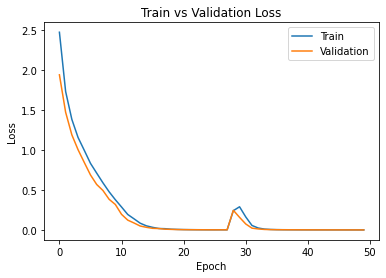

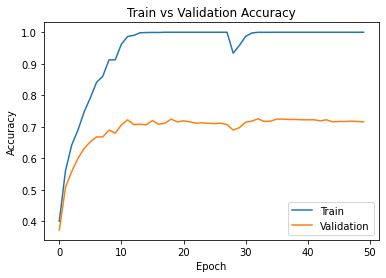

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.7158351409978309


In [ ]:
model_lstm = LSTM(50, 200, 26)
train_RNN(model_lstm, train_loader, valid_loader, num_epochs=50, learning_rate=5e-3)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.48481546735905046, Train loss: 2.091660083134969 |Validation acc: 0.4753183324611896, Validation loss: 1.6714454919320565
Epoch 2: Train acc: 0.5347273738872403, Train loss: 1.6568343402721264 |Validation acc: 0.5150880865166579, Validation loss: 1.5260939248402914
Epoch 3: Train acc: 0.5166218471810089, Train loss: 1.5760082855931035 |Validation acc: 0.49572649572649574, Validation loss: 1.5164895169823258
Epoch 4: Train acc: 0.5460636127596439, Train loss: 1.5265583284695943 |Validation acc: 0.5264259549973835, Validation loss: 1.4838151293330721
Epoch 5: Train acc: 0.5515346810089021, Train loss: 1.4700257393165872 |Validation acc: 0.5356706785278214, Validation loss: 1.4365899569016916
Epoch 6: Train acc: 0.5887425816023739, Train loss: 1.4458193811663875 |Validation acc: 0.5644514215942787, Validation loss: 1.2994193234267057
Epoch 7: Train acc: 0.5860070474777448, Train loss: 1.423365870140217 |Validation acc: 0.563230

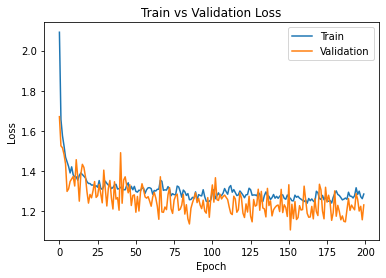

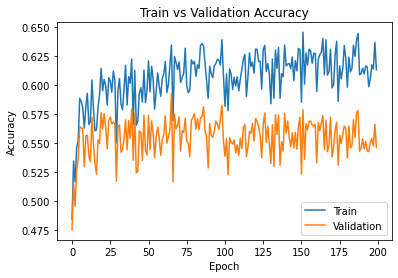

Final Training Accuracy: 0.6133160237388724
Final Validation Accuracy: 0.5461364032792604


In [ ]:
use_cuda = True
model_rnn = RNN(50, 200, 26)

if use_cuda and torch.cuda.is_available():
    model_rnn.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train_RNN(model_rnn, train_loader, valid_loader, num_epochs=200, learning_rate=5e-3)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.35823905786350146, Train loss: 2.4262263345718384 |Validation acc: 0.34467120181405897, Validation loss: 1.9915509098547477
Epoch 2: Train acc: 0.4631166543026706, Train loss: 1.807963264606617 |Validation acc: 0.4427001569858713, Validation loss: 1.652059343126085
Epoch 3: Train acc: 0.5233911350148368, Train loss: 1.561788385355914 |Validation acc: 0.5061922204779348, Validation loss: 1.4554678377398738
Epoch 4: Train acc: 0.5750417284866469, Train loss: 1.405968116124471 |Validation acc: 0.5466596895168324, Validation loss: 1.3078008113084016
Epoch 5: Train acc: 0.6054571587537092, Train loss: 1.3010323153601753 |Validation acc: 0.5785801500087214, Validation loss: 1.2218991952472262
Epoch 6: Train acc: 0.6179988872403561, Train loss: 1.2143395616390087 |Validation acc: 0.5825920111634397, Validation loss: 1.1701666383390072
Epoch 7: Train acc: 0.6380517433234422, Train loss: 1.1487506382553665 |Validation acc: 0.60613989

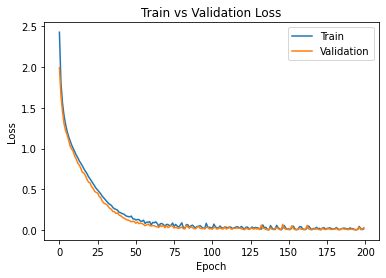

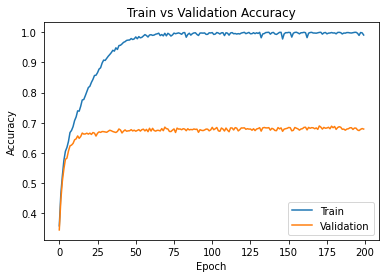

Final Training Accuracy: 0.9905647255192879
Final Validation Accuracy: 0.6788766788766789


In [ ]:
use_cuda = True
model_lstm_1 = LSTM(50, 200, 26)

if use_cuda and torch.cuda.is_available():
    model_lstm_1.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train_RNN(model_lstm_1, train_loader, valid_loader, num_epochs=200, learning_rate=5e-4)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.642549146884273, Train loss: 1.636104885648798 |Validation acc: 0.6164311878597593, Validation loss: 1.1293088997734917
Epoch 2: Train acc: 0.7072978486646885, Train loss: 1.064190700010017 |Validation acc: 0.6591662305948021, Validation loss: 0.9247390392091539
Epoch 3: Train acc: 0.7461748887240356, Train loss: 0.9168577888276842 |Validation acc: 0.6677132391418106, Validation loss: 0.7986630674644752
Epoch 4: Train acc: 0.7881352002967359, Train loss: 0.8147458227917 |Validation acc: 0.6917844060701204, Validation loss: 0.6764863324165344
Epoch 5: Train acc: 0.8128941023738873, Train loss: 0.7126289917804577 |Validation acc: 0.6961451247165533, Validation loss: 0.5949408974691673
Epoch 6: Train acc: 0.8481083086053413, Train loss: 0.6269910567557371 |Validation acc: 0.699808128379557, Validation loss: 0.48972263389163545
Epoch 7: Train acc: 0.8695752967359051, Train loss: 0.5478648074247219 |Validation acc: 0.702424559567

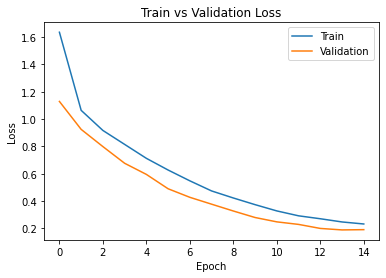

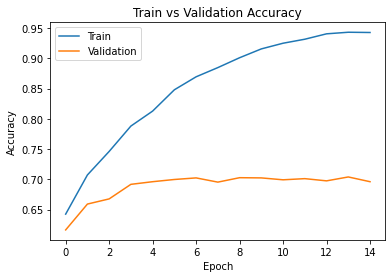

Final Training Accuracy: 0.9428319732937686
Final Validation Accuracy: 0.6961451247165533


In [ ]:
use_cuda = True
model_lstm_2 = LSTM(50, 200, 26)

if use_cuda and torch.cuda.is_available():
    model_lstm_2.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train_RNN(model_lstm_2, train_loader, valid_loader, num_epochs=15, learning_rate=5e-3)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.6396513353115727, Train loss: 1.6370834204885694 |Validation acc: 0.6145124716553289, Validation loss: 1.140975932015313
Epoch 2: Train acc: 0.7108679525222552, Train loss: 1.0761195424751 |Validation acc: 0.6718995290423861, Validation loss: 0.909204290398845
Epoch 3: Train acc: 0.7395910608308606, Train loss: 0.9202572516158775 |Validation acc: 0.6741671027385313, Validation loss: 0.806210789459723
Epoch 4: Train acc: 0.7805777077151336, Train loss: 0.8062047504937208 |Validation acc: 0.6896912611198326, Validation loss: 0.6909413739266219
Epoch 5: Train acc: 0.824392618694362, Train loss: 0.7118226208068706 |Validation acc: 0.6975405546834118, Validation loss: 0.5742609855643025
Epoch 6: Train acc: 0.8495456231454006, Train loss: 0.6290890523018661 |Validation acc: 0.7046921332635618, Validation loss: 0.4917218741884938
Epoch 7: Train acc: 0.8700157640949555, Train loss: 0.5436784017748303 |Validation acc: 0.7020757020757

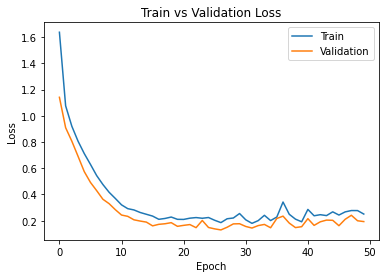

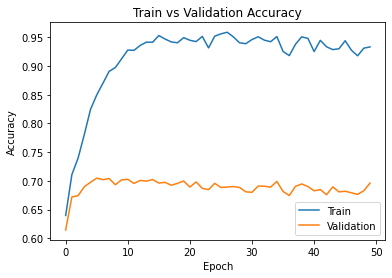

Final Training Accuracy: 0.9332576038575667
Final Validation Accuracy: 0.6961451247165533


In [24]:
use_cuda = True
model_lstm_3 = LSTM(50, 200, 26)

if use_cuda and torch.cuda.is_available():
    model_lstm_3.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train_RNN(model_lstm_3, train_loader, valid_loader, num_epochs=50, learning_rate=5e-3)

## Testing

In [ ]:
test_loader = ReviewBatcher(test, batch_size=64, drop_last=False)   

In [ ]:
test_acc_rnn = get_accuracy(model_rnn, test_loader)       
print("The final test accuracy of my RNN model is", test_acc_rnn*100, "%")      

The final test accuracy of my RNN model is 56.06139891854177 %


In [ ]:
test_acc_lstm = get_accuracy(model_lstm_3, test_loader)       
print("The final test accuracy of my LSTM model is", test_acc_lstm*100, "%")   

The final test accuracy of my LSTM model is 69.91104133961277 %


In [ ]:
test_loader_1 = ReviewBatcher(test, batch_size=64, shuffle=False, drop_last=False) 

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, test_loader):
    i = 0

    for inputs, labels in test_loader:
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        if i == 0:
            predication = (outputs.data).cpu().numpy()
            truth = labels.cpu().numpy()
        else:
            predication = np.concatenate((predication, (outputs.data).cpu().numpy()), axis=0)
            truth = np.concatenate((truth, labels.cpu().numpy()), axis=0)
        i = i + 1

    prediction = predication
    ground_truth = truth
    return confusion_matrix(np.squeeze(ground_truth), np.argmax(prediction, axis=1))

In [ ]:
cm = get_confusion_matrix(model_lstm_3, test_loader_1)

In [ ]:
cm

array([[ 57,   0,   0,   0,   0,   2,   5,   0,   2,   0,   2,   2,   4,
          2,   0,   8,   0,  18,   0,   0,   4,   3,   0,   0,   0,   8],
       [  0, 196,   0,   0,   0,   2,   0,   8,   0,   8,   0,   0,   0,
          0,   2,   0,  12,   0,  14,   0,   0,   1,   5,   0,   0,   0],
       [  0,   0, 108,   0,   0,   0,   5,   0,   0,   0,  10,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  30,   0,   0],
       [  0,   0,   0, 149,   0,   3,   8,   0,   0,   0,   7,   4,   0,
          0,   0,   2,   0,   2,   0,   0,   2,  10,   0,   1,   0,   1],
       [  0,   0,   0,   0,  63,   2,   0,   6,   0,   0,   0,   0,   1,
          0,   3,   0,   0,   0,  12,   4,   0,   0,   4,   0,   1,   0],
       [  0,   1,   0,   1,   4, 210,  21,   4,   4,   1,   3,   2,   3,
          1,   1,   0,   3,   2,  10,   2,   2,   2,  11,   1,   7,   2],
       [  2,   0,   1,   4,   0,  20, 668,   2,  14,   1,   6,  17,   3,
          7,   0,   9,   2,  24,  14,   0,   

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [ ]:
TP

array([ 57, 196, 108, 149,  63, 210, 668, 176,  95,  37, 297,  66, 118,
       347,  51,  47,  61, 256, 485,  37,  32, 141, 100, 112,  59,  40])

In [ ]:
TN

array([5595, 5453, 5553, 5528, 5616, 5359, 4655, 5393, 5551, 5668, 5184,
       5520, 5541, 5201, 5633, 5612, 5590, 5138, 4952, 5646, 5600, 5446,
       5522, 5491, 5622, 5531])

In [ ]:
FP

array([ 21,  32,  26,  16,  21,  76, 243,  68,  50,  16,  96,  82,  38,
        58,  14,  39,  49, 167, 176,  25,  55,  81,  76,  77,  31,  92])

In [ ]:
FN

array([ 60,  52,  46,  40,  33,  88, 167,  96,  37,  12, 156,  65,  36,
       127,  35,  35,  33, 172, 120,  25,  46,  65,  35,  53,  21,  70])

In [ ]:
TPR

array([0.48717949, 0.79032258, 0.7012987 , 0.78835979, 0.65625   ,
       0.70469799, 0.8       , 0.64705882, 0.71969697, 0.75510204,
       0.65562914, 0.50381679, 0.76623377, 0.73206751, 0.59302326,
       0.57317073, 0.64893617, 0.59813084, 0.80165289, 0.59677419,
       0.41025641, 0.68446602, 0.74074074, 0.67878788, 0.7375    ,
       0.36363636])

In [ ]:
PPV

array([0.73076923, 0.85964912, 0.80597015, 0.9030303 , 0.75      ,
       0.73426573, 0.73326015, 0.72131148, 0.65517241, 0.69811321,
       0.75572519, 0.44594595, 0.75641026, 0.85679012, 0.78461538,
       0.54651163, 0.55454545, 0.60520095, 0.73373676, 0.59677419,
       0.36781609, 0.63513514, 0.56818182, 0.59259259, 0.65555556,
       0.3030303 ])

In [ ]:
ACC

array([0.98587127, 0.98534799, 0.98744113, 0.99023199, 0.99058085,
       0.97139369, 0.92848421, 0.97139369, 0.9848247 , 0.995116  ,
       0.95604396, 0.97435897, 0.98709227, 0.96773068, 0.99145299,
       0.98709227, 0.98569684, 0.94086866, 0.94836909, 0.99127856,
       0.9823827 , 0.9745334 , 0.98063841, 0.97732426, 0.99092971,
       0.97174254])

In [ ]:
TP.sum()/cm.sum()

0.6991104133961277

## Demonstration

### Demonstration 1 - Example Description From Test Set

In [ ]:
input = df.values[2]

In [ ]:
input_description = input[0]
input_variety = input[1]
print("The input wine description is:", input_description)
print("The corresponding grape variety is:", input_variety)

The input wine description is: 
                      Alluring notes of ripe citrus shine in the glass. There is mandarin, clementine as well as something fresh and green like crushed citrus foliage. The palate reprises this panoply of ripe citrus in a joyful fashion, with ease but also with concentration and verve. There is lightness in its step and vivid but ripe citrus freshness that makes the taste buds tingle. The finish is dry and lip-smacking.                      
The corresponding grape variety is: Riesling


In [ ]:
input_embedding = [glove.stoi[w] for w in split_word(input_description) if w in glove.stoi]

In [ ]:
print("The input embedding is:", input_embedding)

The input embedding is: [35224, 2142, 3, 13711, 14694, 11835, 6, 0, 2847, 2, 63, 14, 14939, 1, 51985, 19, 143, 19, 645, 1903, 5, 989, 117, 7357, 14694, 19048, 2, 0, 28034, 61073, 37, 61495, 3, 13711, 14694, 6, 7, 27779, 2535, 1, 17, 3586, 34, 52, 17, 5678, 5, 32271, 2, 63, 14, 43806, 6, 47, 1065, 5, 12744, 34, 13711, 14694, 33564, 12, 907, 0, 4374, 26852, 67792, 2, 0, 1624, 14, 3289, 5, 2]


In [ ]:
pred = model_lstm_3(torch.tensor(input_embedding).unsqueeze(0).cuda())

In [ ]:
print("The predicted grape variety is", get_variety_value(np.argmax(pred.cpu().detach().numpy())))

The predicted grape variety is Riesling


### Demonstration 2 - Recommendation Based on Personal Taste Preferences

In [ ]:
personal_description = "A wine with flavors of blackberries and blueberries that is tight and firm on the palate, finishing with a toasted oak accent."
print("The input wine description is:", personal_description)

The input wine description is: A wine with flavors of blackberries and blueberries that is tight and firm on the palate, finishing with a toasted oak accent.


In [ ]:
personal_embedding = [glove.stoi[w] for w in split_word(personal_description) if w in glove.stoi]

In [ ]:
print("The input embedding is:", personal_embedding)

The input embedding is: [7, 2760, 17, 12675, 3, 57504, 5, 42049, 12, 14, 3178, 5, 1001, 13, 0, 28034, 1, 3718, 17, 7, 24562, 6513, 10983, 2]


In [ ]:
pred = model_lstm_3(torch.tensor(personal_embedding).unsqueeze(0).cuda())

In [ ]:
print("The recommended grape variety is", get_variety_value(np.argmax(pred.cpu().detach().numpy())))

The recommended grape variety is Tempranillo
